In [19]:
import sys
import os
# from pathlib import Path
# import pandas as pd
# import warnings

# Add the Regression sister folder to sys.path
regression_folder_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Regression'))
sys.path.append(regression_folder_path)

# Import modules
from Regression_variables import *

# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"


# Use random forrest, random split and TPE sampler w/ best params
### n_est = 437
### max_depth = 14 #not too deep so as to avoid overfitting
### min_sample_split = 2
### min_sample_leaf = 1
### x_train_strat, x_test_strat, y_train_strat, y_test_strat = strat_pIC50_split(compounds)

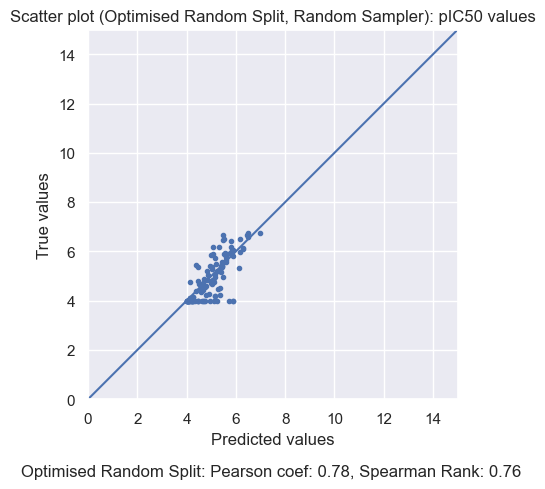

In [20]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rfr_rand_best, y_test_rand, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Optimised Random Split, Random Sampler): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)

pearsoncoef_rfr_rand_best = np.corrcoef(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand_best = spearmanr(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten()).correlation

fig.text(0.9, -0.05, f"Optimised Random Split: Pearson coef: {pearsoncoef_rfr_rand_best:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best:.2f}", horizontalalignment='right', fontsize=12)

plt.show();

# SHAP Values

In [21]:
import shap
shap.initjs()

In [22]:
explainer = shap.Explainer(rfr_rand_best)
shap_values = explainer(np.array(list((x_train_rand))).astype(float))

In [23]:
np.shape(shap_values.values)
#MACCS keys are 166bit structural key descriptors

(476, 167)

# Waterfall Plot
### This tells us the waterfall plot for the first observation LHS 0 and 1 show the actual value of obs 1. Feature # tells us the MACCS bit we are looking at. The arrow tells us how the feature has contributed to the pIC50 prediction

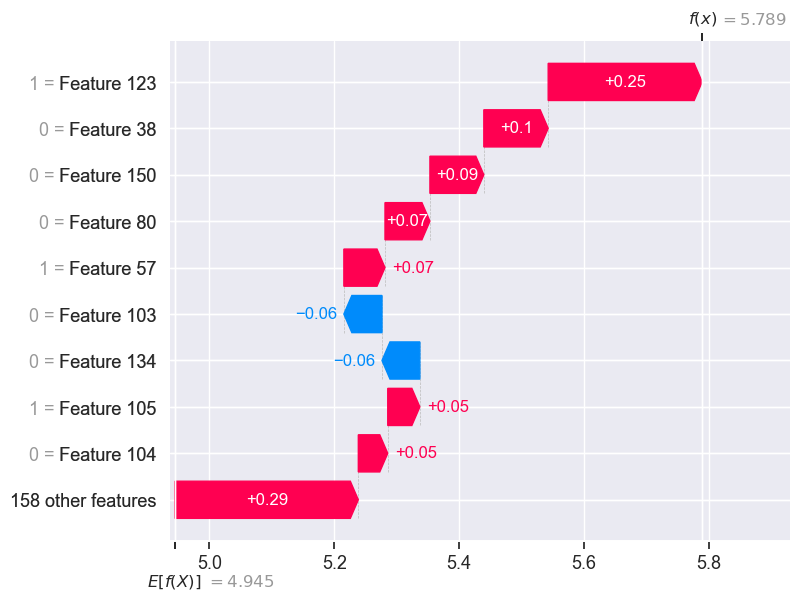

In [24]:
shap.plots.waterfall(shap_values[0])


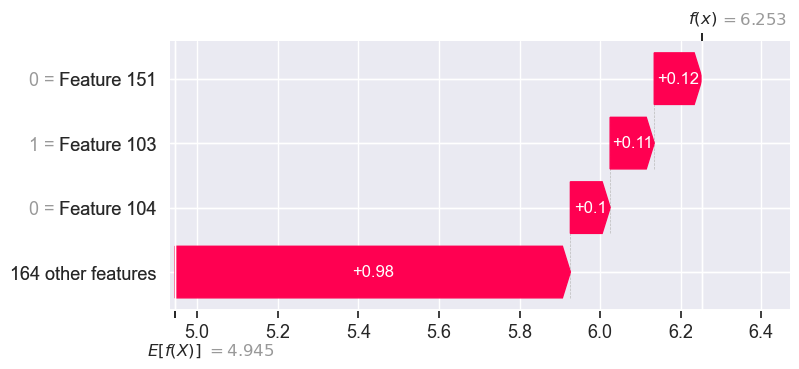

In [25]:
shap.plots.waterfall(shap_values[1], max_display=4)

# Force Plot

In [26]:
# a consended waterfall plot
shap.plots.force(shap_values[0])

# Stacked force plot
### Each of the individual force plots has been flipped 90 degrees and stacked side by side (vertically)

In [27]:
shap.plots.force(shap_values[0:100])

# Absolute Mean SHAP Plot
### Which features are most important to the MODEL
### Each bar gives absolute mean SHAP value for each feature. Features that have made large positive or negative contributions are at the top. 

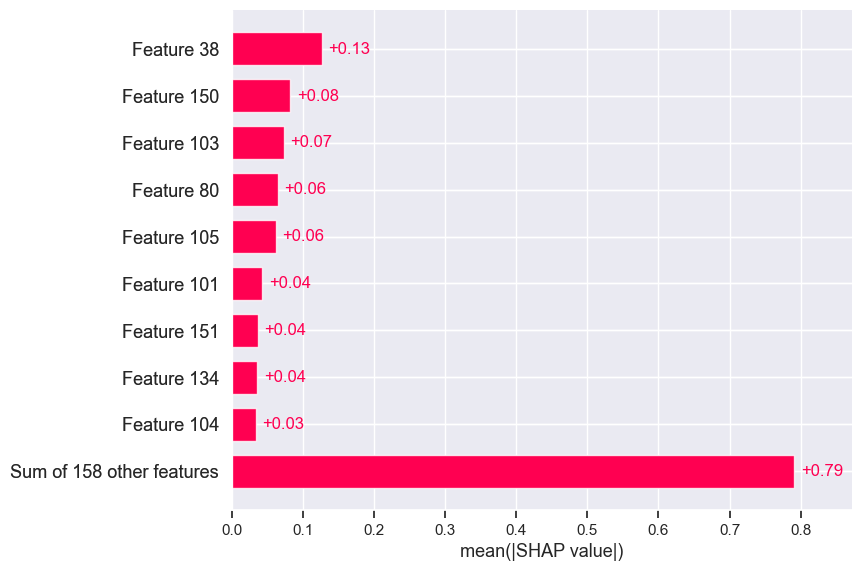

In [28]:
shap.plots.bar(shap_values)

# Beeswarm Plot
### A visualisation of all of the SHAP values
### y axis: Feature #
### x axis: SHAP value
### colour: determined by the feature values 
### We can see which features have large positive or large negative SHAP values. Features have been ordered in same order in abs mean plot
### There is no gradient here as the feature value is binary [0,1]
### Feature 38: a value of 1 contributes to a negative SHAP value whilse for feature 103 this is the opposite. 

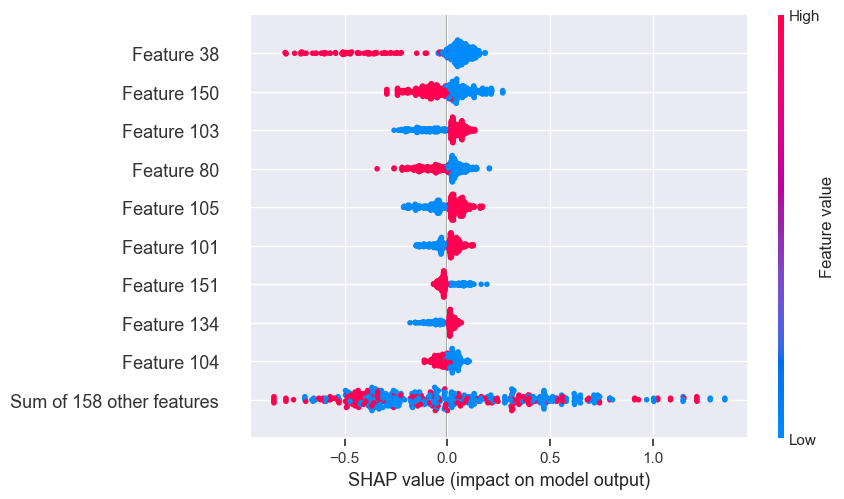

In [29]:
shap.plots.beeswarm(shap_values)